In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import lmfit
import astropy
import astropy.units as u
import corner
from astropy.cosmology import w0waCDM

In [2]:
from scipy import integrate

In [3]:
def H_z(z,H0,Om,Ode,w0,w1):
    Ode=1-Om
    # quad only accepts scalars, so need to use a list comprehension to run through the whole array of z
    b= lambda zz : (1+w0+w1*(zz/(1+zz)))/(1+zz)
    b1=[integrate.quadrature(b,0,zi) for zi in z]
    # Returns a list, so we convert to a numpy array
    B1=np.array(b1)
    B2=B1.reshape(-1, 1)
    x=(Om*(1+z)**3) + (1-Om)*np.exp(3*B1[:,0])
    x1=np.array(x)
    x2=x1.reshape(1,-1)
    Hzz=H0*np.sqrt(x)
    return Hzz

In [4]:
def Hz1(z1,H01,Om1,w01,wa1):
    cosmo = w0waCDM(H0=H01* u.km / u.s / u.Mpc, Om0=Om1,Ode0=1.0-Om1,w0=w01,wa=wa1)
    E=cosmo.efunc(z1)
    HZ1=H01*E
    return HZ1
# def Hz1(Z1,H01,Om1,Ode1,w01,wa1):
#     cosmo = w0waCDM(H0=H01* u.km / u.s / u.Mpc, Om0=Om1,Ode0=Ode1,w0=w01,wa=wa1)
#     E=cosmo.efunc(Z1)
#     HZ1=H01*E
#     return HZ1

In [5]:
#Define  random redshifts
num_zs = 50
zs= np.linspace(0.01, 3., num=num_zs)

In [6]:
#From Planck observations for CPL mode
O_m= 0.3029
O_de= 1-O_m
w_0= -0.9414
w_1= -0.4303
H_0= 68.5265

In [7]:
#Hubble comoving parameter
Hz=H_z(zs,H_0,O_m,1-O_m,w_0,w_1)/(1+zs)

In [8]:
#random error for Hz
error_sigma = 0.5
e1 = np.random.normal(0., error_sigma, Hz.shape)

In [9]:
H_zz= Hz + e1

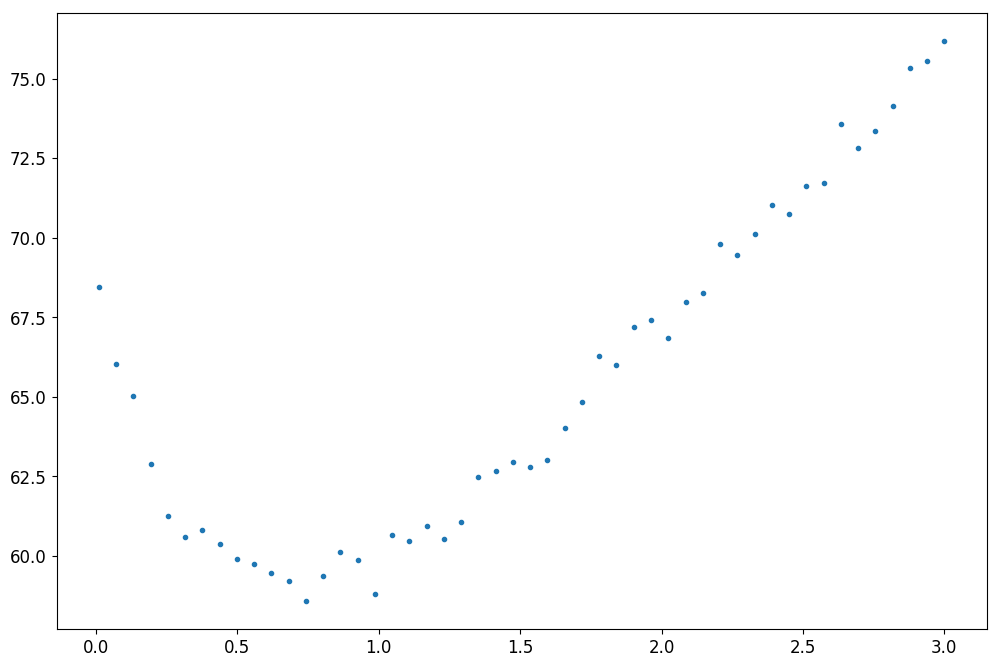

In [10]:
plt.plot(zs,H_zz, '.')

In [11]:
p = lmfit.Parameters()
p.add_many(('Om1',0.3,True,0.,2.),
           ('H01',70.0,True,50.,100.),
#            ('Ode1',0.7,True,0.,2.),
           ('w01',-1.0,True,-2.,2.),
           ('wa1',-0.1,True,-1.,1.))

def residual(p):
    v = p.valuesdict()
    return (Hz1(zs,v['H01'],v['Om1'],v['w01'],v['wa1'])-H_zz)/error_sigma

In [20]:
mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 86
    # data points      = 50
    # variables        = 4
    chi-square         = 49.1264715
    reduced chi-square = 1.06796677
    Akaike info crit   = 7.11875097
    Bayesian info crit = 14.7668430
[[Variables]]
    Om1:  4.9364e-11 +/- 0.00148576 (3009833136.94%) (init = 0.3)
    H01:  68.6531484 +/- 0.37249414 (0.54%) (init = 70)
    w01: -1.40624956 +/- 0.01874509 (1.33%) (init = -1)
    wa1:  0.99657472 +/- 0.07079426 (7.10%) (init = -0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(Om1, wa1) = -0.957
    C(w01, wa1) = -0.950
    C(H01, w01) = -0.872
    C(Om1, w01) =  0.824
    C(H01, wa1) =  0.724
    C(Om1, H01) = -0.557


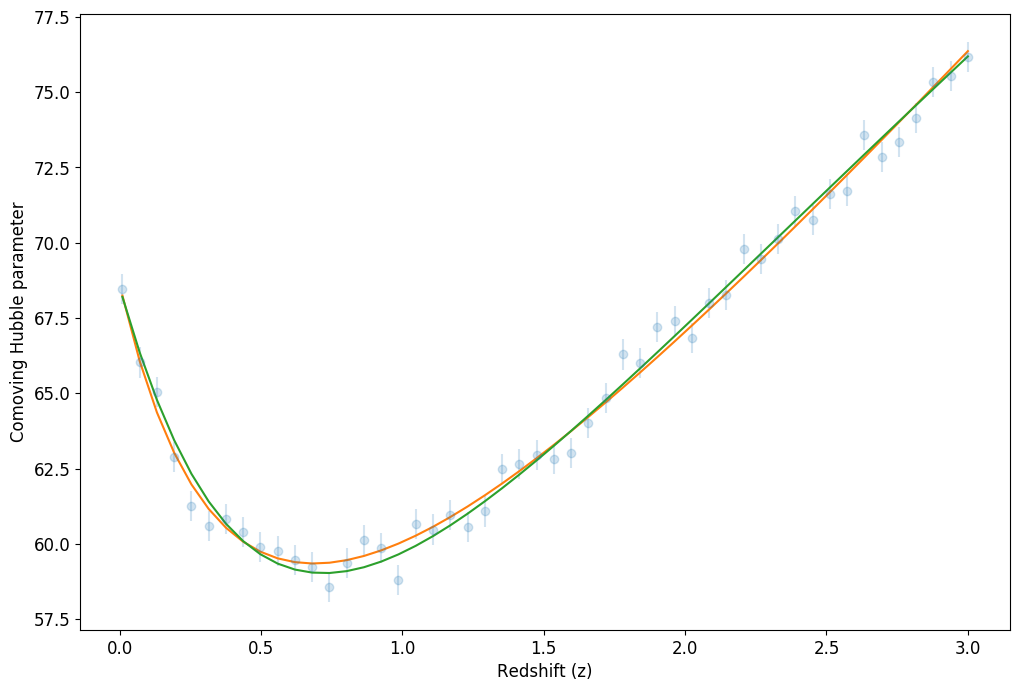

In [23]:
plt.errorbar(zs,H_zz,yerr=error_sigma,fmt='o',alpha=0.2)
bestOm1 = mi.params.valuesdict()['Om1']
bestH01 = mi.params.valuesdict()['H01']
# bestOde1= mi.params.valuesdict()['Ode1']
bestw01 = mi.params.valuesdict()['w01']
bestwa1 = mi.params.valuesdict()['wa1']
plt.plot(zs,Hz1(zs,bestH01,bestOm1,bestw01,bestwa1))
plt.plot(zs,Hz)
plt.xlabel('Redshift (z)')
plt.ylabel('Comoving Hubble parameter')
lmfit.report_fit(mi)

In [17]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=100, steps=5000,thin=1, nwalkers=10,
                         params=p, is_weighted=True, reuse_sampler=False)

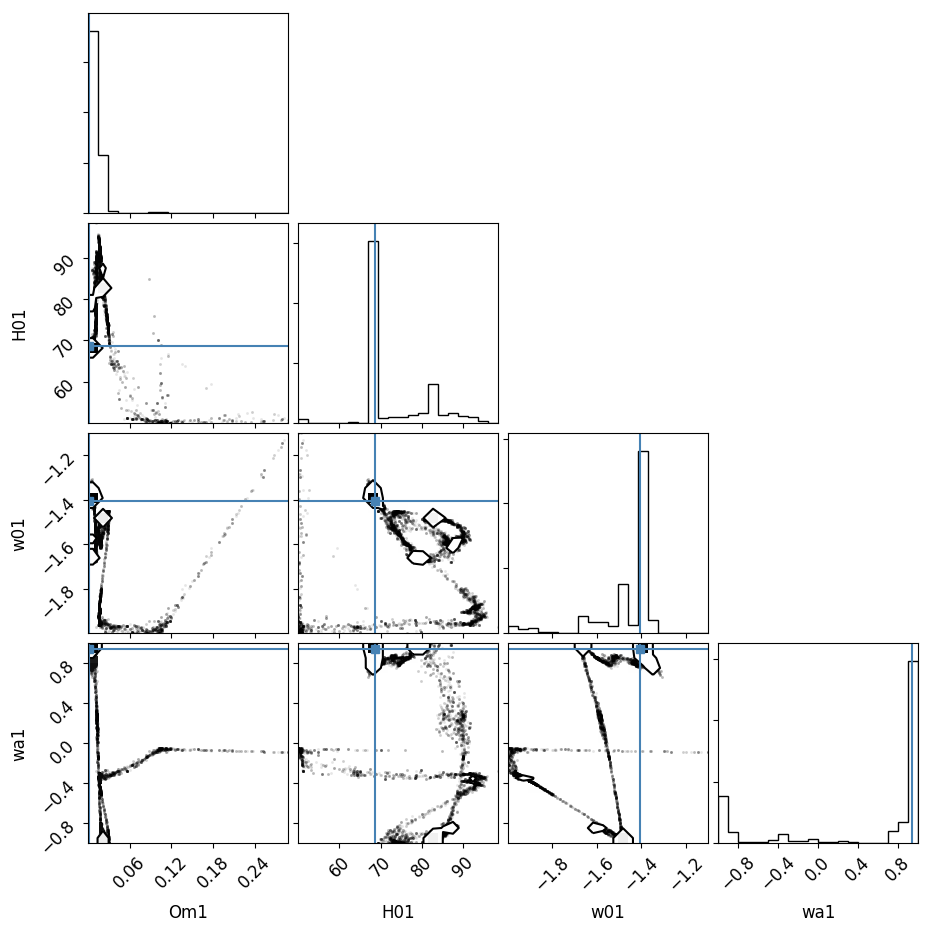

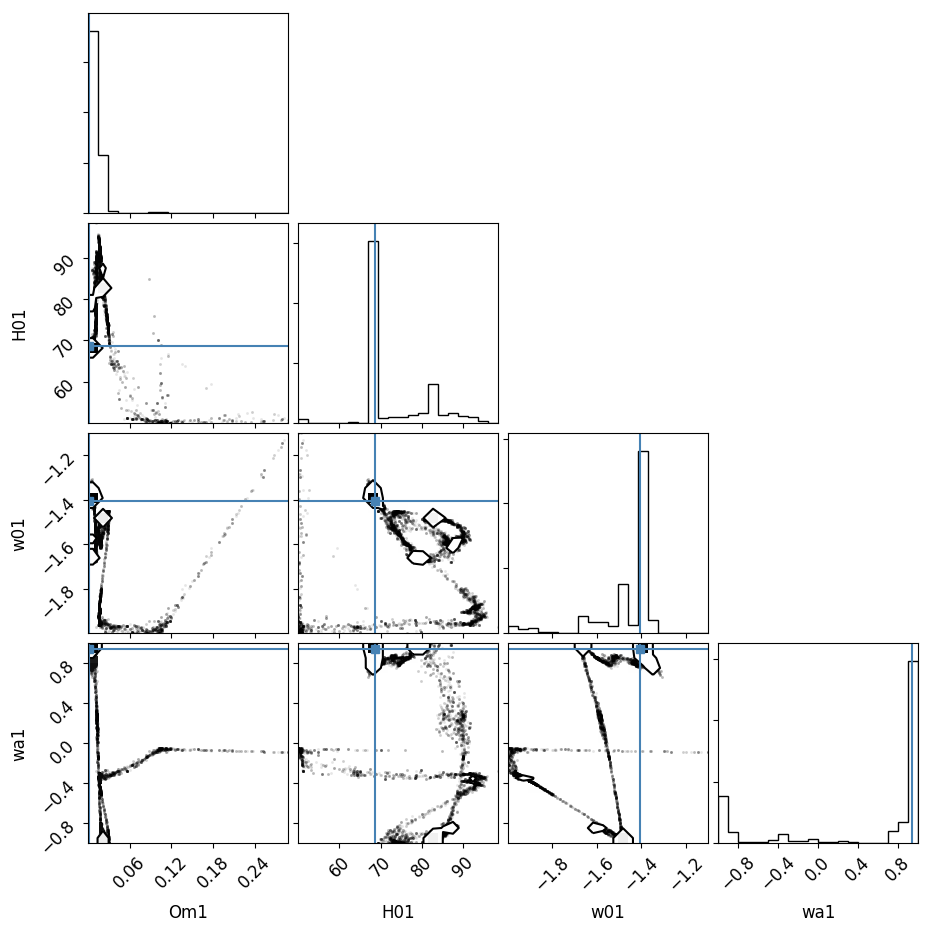

In [18]:
corner.corner(res.flatchain,labels=res.var_names, truths=list(res.params.valuesdict().values()))

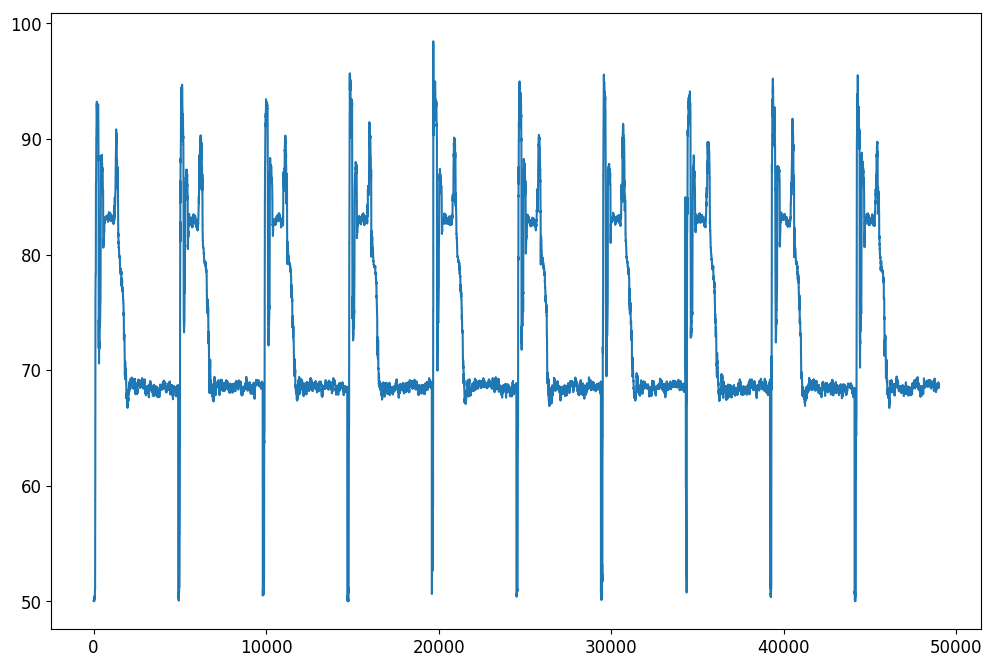

In [19]:
plt.plot(res.flatchain.H01)